In [74]:
!ls -laFh /data/use-cases/ecommerce-conversion-rate/2018-02-campaigns/

total 384K
drwxr-xr-x 3 root root   96 Feb 12 08:22 ./
drwxr-xr-x 3 root root   96 Feb 12 08:22 ../
-rw-r--r-- 1 root root 382K Feb 11 13:58 conversion-rate-exploration.csv.bz2


In [75]:
import pandas as pd
data = pd.read_csv('/data/use-cases/ecommerce-conversion-rate/2018-02-campaigns/conversion-rate-exploration.csv.bz2', sep=';')

In [76]:
# Fix the video_viewed NaN
data['video_viewed'].fillna(0, inplace = True)

# Add a column for the number of views per campaign
data['num_avg_campaigns_looked'] = data['num_campaign_pages_looked'] / data['num_campaigns_looked']

In [77]:
data.head()

,PJ_ID,pj_created_at,recipient_details_gender,mpj,first_device,first_os,first_browser,first_city,last_device,summarized_last_device,...,video_viewed,campaign_viewed,outcome,conversion,num_campaign_pages_looked,num_campaigns_looked,Closed,site visit,PJ count,num_avg_campaigns_looked
0,5qktitft6z5iwmhidall57go,5.2.2017 0:00,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,Fallback,0,0,0,NaN,0,1,NaN
1,rmlwhcgf5nfnf6xf7ukzki3h,5.2.2017 0:00,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,Fallback,0,0,0,NaN,0,1,NaN
2,ua7s4b2q5juco5glcdddiy4y,5.2.2017 0:00,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,Fallback,0,0,0,NaN,0,1,NaN
3,ccz7qde5rtq2vdo7i6zbiwea,5.2.2017 0:00,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,Fallback,0,0,0,NaN,0,1,NaN
4,2kl4dqgupwksxukebhh3dx4h,5.2.2017 0:00,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,Fallback,0,0,0,NaN,0,1,NaN


In [78]:
# Is the data clean -
# Are there duplicate PJ_IDs?
unique_PJ_ID = data.groupby('PJ_ID').agg({'pj_created_at': 'max'})
if (len(data) == len(unique_PJ_ID)):
    print('PJ_ID is unique')
else:
    print('PJ_ID is not unique. Please clean data.')


PJ_ID is unique


In [79]:
# Is the data clean -
# Is the mpj unique for every PJ if he clicked on the invitation email
unique_mpj = data.groupby('mpj').agg({'PJ_ID': 'nunique'})
if len(unique_mpj[unique_mpj['PJ_ID'] !=1]) == 0:
        print('mpj is unique')
else:
    print('mpj is not unique. Please clean data.')

mpj is unique


In [80]:
# Is the data clean
# Is the dataset with customer who did not visit the site clean ?
no_visits =  data[data['site visit'] == 0]
tmp = no_visits.groupby([no_visits.columns[15]]).agg({'PJ_ID': 'nunique'})
print(tmp)
tmp = no_visits.groupby([no_visits.columns[16]]).agg({'PJ_ID': 'nunique'})
print(tmp)
# How potential targets are converting without visiting the site ?

             PJ_ID
outcome           
Combination     16
Fallback      3450
Payout         815
Voucher         37
            PJ_ID
conversion       
0            4265
1              53


In [81]:
# Conversion statistics by two variables (outcome, gender) on non site visit data (suspicious)
no_visits_group = no_visits.groupby(['outcome', 'recipient_details_gender']).agg({'conversion':'sum'})
no_visits_group
# Conclusion - Not sure how people who do not visit the site gets converted. Needs more exploration with business.

conversion
outcome     recipient_details_gender            
Combination Female                             2
            Male                              14
Fallback    Female                             0
            Male                               0
Payout      Female                             0
            Male                               0
Voucher     Female                             6
            Male                              30

In [82]:
# Analysis
# Data ready
visits =  data[data['site visit'] == 1]

In [83]:
# Hypothesis 1: There is a sweet spot made of right combination of campaigns looked and campaign pages landed that gets converted.
visit_campaign_c = visits[(visits['conversion']==1)].groupby(['num_campaign_pages_looked','num_campaigns_looked']).agg({'conversion':'sum', 'Closed':'sum'}).reset_index()
visit_campaign_c.columns = ['num_campaign_pages_looked', 'num_campaigns_looked', 'conversion','closed']


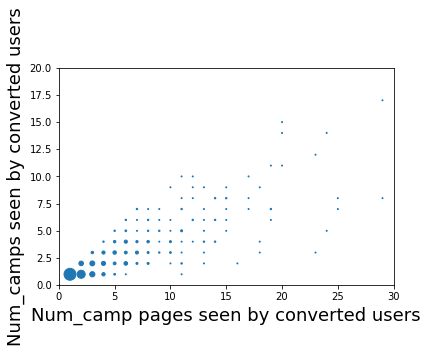

In [84]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.ylim((0,20))
plt.xlim((0,30))
plt.xlabel('Num_camp pages seen by converted users', fontsize=18)
plt.ylabel('Num_camps seen by converted users', fontsize=18)
plt.scatter(visit_campaign_c.num_campaign_pages_looked, visit_campaign_c.num_campaigns_looked
, s=visit_campaign_c.conversion)
# Conclusion, The propsensity to get converted decreases if the user has been not converted in 5 campaign page views.

In [85]:
#The same plot for people who visit but do not convert
visit_campaign_nc = visits[visits['conversion']==0].groupby(['num_campaign_pages_looked','num_campaigns_looked']).agg({'conversion':'count', 'Closed':'sum'}).reset_index()
visit_campaign_nc.columns = ['num_campaign_pages_looked', 'num_campaigns_looked', 'conversion','closed']

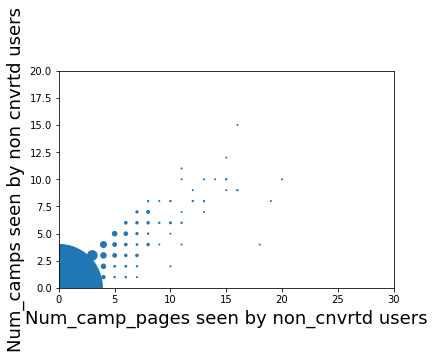

In [86]:
plt.ylim((0,20))
plt.xlim((0,30))
plt.xlabel('Num_camp_pages seen by non_cnvrtd users', fontsize=18)
plt.ylabel('Num_camps seen by non cnvrtd users', fontsize=18)
plt.scatter(visit_campaign_nc.num_campaign_pages_looked, visit_campaign_nc.num_campaigns_looked
, s=visit_campaign_nc.conversion)
# Conclusion, if the user has not converted in 2 views, and then data suddenly disappearing could mean that larger that 2 exposure lead to conversion.
# Hence optimum number of views is between 2 and 5. To improve the product we should try to reach that KPI.

In [87]:
# Hypothesis 2: Video plays an important role 
# Making the same graph on people who never saw the video
visit_campaign_v = visits[(visits['video_viewed'] == 1) & (visits['conversion'] == 1)].groupby(['num_campaign_pages_looked','num_campaigns_looked']).agg({'conversion':'sum', 'Closed':'sum'}).reset_index()
visit_campaign_v.columns = ['num_campaign_pages_looked', 'num_campaigns_looked', 'conversion','closed']

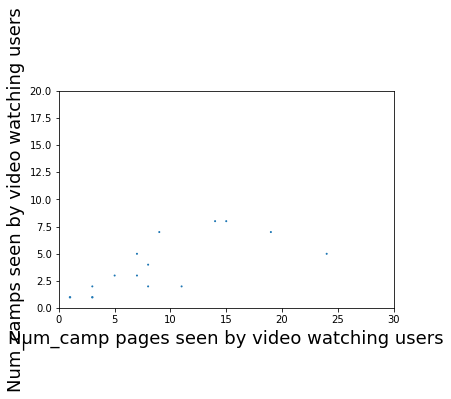

In [88]:
plt.ylim((0,20))
plt.xlim((0,30))
plt.xlabel('Num_camp pages seen by video watching users', fontsize=18)
plt.ylabel('Num_camps seen by video watching users', fontsize=18)
plt.scatter(visit_campaign_v.num_campaign_pages_looked, visit_campaign_v.num_campaigns_looked
, s=visit_campaign_v.conversion)

In [89]:
data_fltd = data[['mpj', 'pj_created_at', 'num_campaigns_looked', 'num_campaign_pages_looked', 'video_viewed', 'outcome', 'conversion']]
data_fltd

,mpj,pj_created_at,num_campaigns_looked,num_campaign_pages_looked,video_viewed,outcome,conversion
0,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
1,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
2,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
3,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
4,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
5,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
6,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
7,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
8,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0
9,NaN,5.2.2017 0:00,0,0,0.0,Fallback,0


In [90]:
data_fltd[data_fltd['conversion'] == 0]['outcome'].unique()

array(['Fallback', 'Payout'], dtype=object)

In [91]:
# Users seeing any campaign are assigned a ``mpj`` ID
tmp = data[(data['num_campaigns_looked'] != 0) & (data['mpj'].isnull())]
tmp

,PJ_ID,pj_created_at,recipient_details_gender,mpj,first_device,first_os,first_browser,first_city,last_device,summarized_last_device,...,video_viewed,campaign_viewed,outcome,conversion,num_campaign_pages_looked,num_campaigns_looked,Closed,site visit,PJ count,num_avg_campaigns_looked


In [92]:
# Time-lines for converted customers
agg_visits_converted = data_fltd[data_fltd['conversion'] == 1].groupby(['pj_created_at'], as_index = False).sum()
agg_visits_converted.head()

,pj_created_at,num_campaigns_looked,num_campaign_pages_looked,video_viewed,conversion
0,5.11.2017 0:00,12,16,0.0,5
1,5.16.2017 0:00,9,16,0.0,7
2,5.18.2017 0:00,12,21,0.0,6
3,5.2.2017 0:00,36,80,1.0,18
4,5.23.2017 0:00,22,43,0.0,14


In [93]:
# Time-lines for non converted customers
agg_visits_nonconverted = data_fltd[data_fltd['conversion'] == 0].groupby(['pj_created_at'], as_index = False).sum()
agg_visits_nonconverted.head()

,pj_created_at,num_campaigns_looked,num_campaign_pages_looked,video_viewed,conversion
0,5.11.2017 0:00,33,48,4.0,0
1,5.16.2017 0:00,78,102,0.0,0
2,5.18.2017 0:00,36,44,0.0,0
3,5.2.2017 0:00,77,96,4.0,0
4,5.23.2017 0:00,57,68,0.0,0


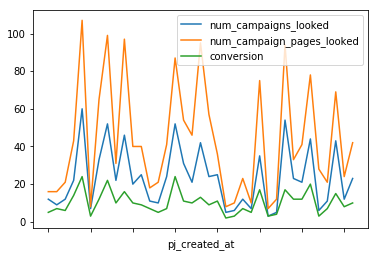

In [94]:
# Converted customers not having watched the video
ax = agg_visits_converted[agg_visits_converted['video_viewed'] == 0].plot (x = 'pj_created_at', y = 'num_campaigns_looked')
agg_visits_converted[agg_visits_converted['video_viewed'] == 0].plot (ax = ax, x = 'pj_created_at', y = 'num_campaign_pages_looked')
agg_visits_converted[agg_visits_converted['video_viewed'] == 0].plot (ax = ax, x = 'pj_created_at', y = 'conversion')

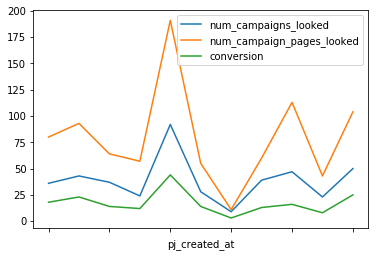

In [95]:
# Converted customers having watched the video
ax = agg_visits_converted[agg_visits_converted['video_viewed'] != 0].plot (x = 'pj_created_at', y = 'num_campaigns_looked')
agg_visits_converted[agg_visits_converted['video_viewed'] != 0].plot (ax = ax, x = 'pj_created_at', y = 'num_campaign_pages_looked')
agg_visits_converted[agg_visits_converted['video_viewed'] != 0].plot (ax = ax, x = 'pj_created_at', y = 'conversion')

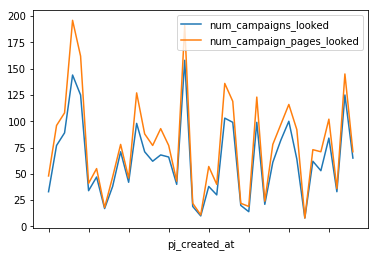

In [96]:
# Non converted users having watched the video
ax = agg_visits_nonconverted[agg_visits_nonconverted['video_viewed'] != 0].plot (x = 'pj_created_at', y = 'num_campaigns_looked')
agg_visits_nonconverted[agg_visits_nonconverted['video_viewed'] != 0].plot (ax = ax, x = 'pj_created_at', y = 'num_campaign_pages_looked')

